<a href="https://colab.research.google.com/github/rhodes-byu/cs180-winter25/blob/main/notebooks/15-random-forests
.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Random Forests

Random Forests are ensemble learning methods that build multiple decision trees and aggregate their predictions to improve accuracy and generalization. They are widely used in classification and regression tasks due to their robustness and ability to handle complex data structures.

## Process of Random Forests

### 1. Bootstrap Sampling
Random Forests use **bootstrap aggregation (bagging)** to create diverse training datasets. Each tree in the forest is trained on a randomly sampled subset of the training data, drawn **with replacement**. This means some instances may appear multiple times in a subset, while others may be omitted.

### 2. Random Feature Selection
At each split in a tree, only a **random subset of features** is considered rather than all available features. This prevents dominance of strong predictors and encourages diversity among trees, reducing overfitting.

### 3. Splitting Using Gini Impurity
For classification problems, splits in the decision trees are typically determined by **Gini impurity**, which measures the probability of incorrect classification at a given node. The Gini impurity for a node is calculated as:

$$
G(I) = 1 - \sum_{i=1}^{C} p_i^2
$$

where:
- $ C $ is the number of classes,
- $ p_i $ is the proportion of samples belonging to class $ i $ in the node.

A lower Gini impurity value indicates a purer node, meaning the data points in that node belong mostly to a single class. The best split is chosen to minimize the weighted Gini impurity of the resulting child nodes.

### 4. Other Hyperparameters
Several additional arguments can be tuned to control the behavior of the forest:
   - `n_estimators`: Number of trees in the forest.
   - `max_features`: Number of randomly selected features at each split.
   - `min_samples_split`: Minimum number of samples required to split an internal node.
   - `min_samples_leaf`: Minimum number of samples required to be in a leaf node.
   - `max_depth`: Limits tree growth to prevent overfitting.

### 5. Generally Grown to Maximal Depth
In many implementations, trees are **fully grown** until all leaves are pure (i.e., contain only a single class) or reach a minimum leaf size. Unlike pruning methods used in individual decision trees, Random Forests rely on ensemble averaging to reduce overfitting rather than restricting tree depth.

### 6. Low Bias, Low Variance
Random Forests strike a balance between bias and variance:
   - **Low bias**: Trees have high capacity to learn complex patterns.
   - **Low variance**: Averaging multiple decorrelated trees reduces overfitting and improves generalization.

### 7. Minimizing Correlation Between Trees
To maximize the benefits of ensemble learning, Random Forests aim to **minimize correlation** among trees. This is achieved through:
   - **Bootstrap sampling**, which ensures different training data for each tree.
   - **Random feature selection**, which forces trees to explore different parts of the feature space.

By reducing tree correlation, the variance of the overall model is reduced, making it more robust to noise and improving predictive performance.

### 8. Out-of-Bag (OOB) Points for Model Validation
Since each tree in a Random Forest is trained on a **bootstrap sample**, about **37% of the training data** is **not used** to train a given tree. These **out-of-bag (OOB) samples** serve as a built-in validation set.

- The OOB samples are used to evaluate model performance **without requiring a separate validation set**.
- Each data point is predicted using only the trees **where it was not included in training**.
- The OOB error, computed as the average error across these predictions, provides an **unbiased estimate of test error**.

This method makes Random Forests highly efficient, as they internally estimate generalization performance without requiring cross-validation.

### 9. Aggregating Predictions
Random Forests aggregate the predictions from all individual trees to make a final prediction:

- **Classification**: Each tree casts a vote for a class label, and the final prediction is determined by the **majority vote** (i.e., the class that receives the most votes) :contentReference[oaicite:0]{index=0}.
- **Regression**: Each tree provides a numerical prediction, and the final prediction is obtained by computing the **average** of all tree predictions :contentReference[oaicite:1]{index=1}.

This aggregation process enhances the model's robustness and accuracy by combining the strengths of multiple trees.

## Benefits of Random Forests

Random Forests offer several advantages that make them a popular choice for many machine learning tasks:

- **Easy to use and provide a good baseline**: They work well with minimal tuning and can serve as a strong initial model.
- **Scale invariant**: Unlike some models, Random Forests do not require feature scaling (e.g., standardization or normalization).
- **Used for both classification and regression**: They are flexible and applicable to a wide range of supervised learning tasks.
- **Feature importance measurement**: They provide estimates of feature importance, which can help with feature selection and model interpretability.
- **Handle mixed variable types**: They work with both categorical and numerical features without requiring extensive preprocessing.
- **Strong out-of-the-box performance**: Even with default hyperparameters, Random Forests often yield competitive results.
- **Model non-linear relationships**: They can capture complex patterns and interactions between features without requiring explicit feature engineering.

## Additional Uses of Random Forests

Beyond traditional classification and regression, Random Forests have several additional applications:

### 1. Generation of Random Forest Proximities
Random Forests can compute **proximities** between data points by measuring how often two instances end up in the same leaf node across all trees in the forest. These proximity measures have various applications:

   - **Cluster analysis**: By analyzing proximities, one can detect natural groupings in data without predefined clusters.
   - **Anomaly detection**: Outliers often have low proximity to other data points, making it possible to flag unusual observations.
   - **Data visualization (e.g., multidimensional scaling)**: Proximities can be used to project high-dimensional data into a lower-dimensional space for visualization.
   - **Similarity-based recommendation systems**: Items or users with high proximity can be grouped to provide recommendations.

### 2. Missing Data Imputation
Since Random Forests can estimate proximity between samples, they can be used to **impute missing values** by averaging values from the most similar instances. This method often performs well, especially when missing data is **not missing completely at random (MCAR)**.

### 3. Outlier Detection
Random Forests can be used to **detect outliers** by analyzing proximity distributions. Data points that are consistently dissimilar to all others (i.e., have low average proximity to other points) can be flagged as potential anomalies. 


# Ideas:

- Do each of the additional features: outlier detection, feature importance, proximities, etc.
- Demonstrate non-overfitting with increasing trees
    

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.base import clone
import pandas as pd
import seaborn as sns
import time

### Tic-tac-toe dataset
[Data Link Here](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame)

In [62]:
tic_tac_toe = fetch_openml(name='tic-tac-toe', version=1, parser = 'auto')
X = tic_tac_toe.data
y = tic_tac_toe.target

In [63]:
X.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square
0,x,x,x,x,o,o,x,o,o
1,x,x,x,x,o,o,o,x,o
2,x,x,x,x,o,o,o,o,x
3,x,x,x,x,o,o,o,b,b
4,x,x,x,x,o,o,b,o,b


In [64]:
y.head()

0    positive
1    positive
2    positive
3    positive
4    positive
Name: Class, dtype: category
Categories (2, object): ['negative', 'positive']

### Integer-encoded values

In [65]:
# Inteter-valued encoding
X_enc = X.apply(lambda x: pd.Categorical(x).codes if x.dtype == 'category' else x)
X_enc_train, X_enc_test, y_train, y_test = train_test_split(X_enc, y, test_size = 0.2, random_state = 42)

In [66]:
X_enc.columns

Index(['top-left-square', 'top-middle-square', 'top-right-square',
       'middle-left-square', 'middle-middle-square', 'middle-right-square',
       'bottom-left-square', 'bottom-middle-square', 'bottom-right-square'],
      dtype='object')

In [67]:
X_enc.head()

,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square
0,2,2,2,2,1,1,2,1,1
1,2,2,2,2,1,1,1,2,1
2,2,2,2,2,1,1,1,1,2
3,2,2,2,2,1,1,1,0,0
4,2,2,2,2,1,1,0,1,0


#### Fit the Random Forest on the Encoded data
Check fit using the OOB data

In [68]:
rf_enc = RandomForestClassifier(n_estimators = 100, random_state = 42, oob_score = True) # oob_score to estimate the generalization error
rf_enc.fit(X_enc_train, y_train)

RandomForestClassifier(oob_score=True, random_state=42)

In [69]:
# Note the underscrore_; this is the internally stored OOB accuracy
rf_enc.oob_score_

0.9321148825065274

In [70]:
y_pred_enc = rf_enc.predict(X_enc_test)
print(accuracy_score(y_test, y_pred_enc))

0.9375


#### Feature Importance
The mean decrease in Gini impurity

In [71]:
importances = rf_enc.feature_importances_
print(importances)

[0.10713672 0.09305976 0.11819595 0.09685569 0.14879301 0.09592812
 0.12339304 0.0973656  0.11927211]


<Axes: ylabel='None'>

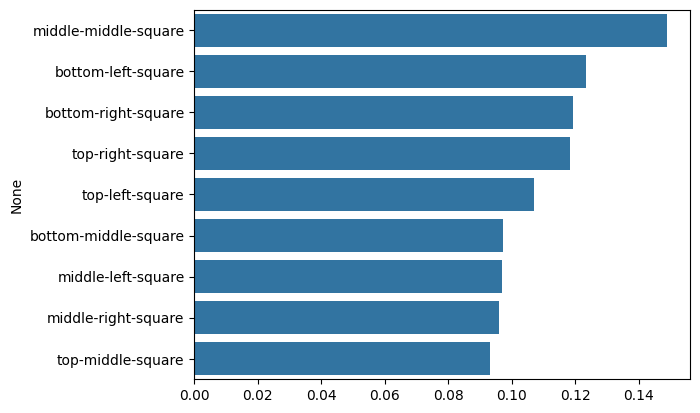

In [72]:
sns.barplot(x = np.sort(importances)[::-1], y = X_enc.columns[np.argsort(importances)][::-1])

### One-hot Encoded Values

In [73]:
X_hot = pd.get_dummies(X)
print(X_hot.shape)

(958, 27)


In [74]:
X_hot_train, X_hot_test, y_train, y_test = train_test_split(X_hot, y, test_size=0.2, random_state=42)

In [75]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42, oob_score = True)
rf.fit(X_hot_train, y_train)

RandomForestClassifier(oob_score=True, random_state=42)

In [76]:
# Add blurb about OOB Score
rf.oob_score_

0.9712793733681462

In [77]:
y_pred_hot = rf.predict(X_hot_test)
print(accuracy_score(y_test, y_pred_hot))

0.9947916666666666


In [78]:
# Add blurb about feature importance

rf.feature_importances_
X_hot.columns[np.argsort(rf.feature_importances_)[::-1]]

Index(['middle-middle-square_o', 'middle-middle-square_x',
       'bottom-right-square_x', 'bottom-right-square_o',
       'bottom-left-square_o', 'top-right-square_x', 'top-right-square_o',
       'bottom-left-square_x', 'top-left-square_o', 'top-left-square_x',
       'top-middle-square_o', 'middle-left-square_x', 'bottom-middle-square_x',
       'top-middle-square_x', 'middle-left-square_o', 'middle-right-square_x',
       'bottom-middle-square_o', 'middle-right-square_o',
       'middle-left-square_b', 'middle-right-square_b',
       'bottom-middle-square_b', 'top-middle-square_b', 'bottom-left-square_b',
       'bottom-right-square_b', 'top-right-square_b', 'middle-middle-square_b',
       'top-left-square_b'],
      dtype='object')

<Axes: ylabel='None'>

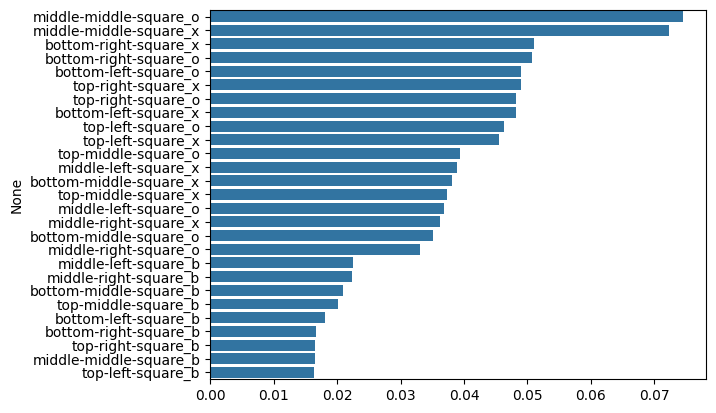

In [79]:
sns.barplot(x = np.sort(rf.feature_importances_)[::-1], y = X_hot.columns[np.argsort(rf.feature_importances_)][::-1])

### Effect of n_estimators (Number of Trees) on accuracy

In [80]:
for n in [1, 5, 10, 50, 100, 500, 1000]:
    start_time = time.time()
    rf = RandomForestClassifier(n_estimators=n, random_state=42, oob_score=True)
    rf.fit(X_hot_train, y_train)
    end_time = time.time()
    print(f"n = {n}: OOB Score = {rf.oob_score_}, Time to fit = {end_time - start_time:.4f} seconds")

c:\Users\rhodes8\AppData\Local\miniconda3\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\rhodes8\AppData\Local\miniconda3\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\rhodes8\AppData\Local\miniconda3\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


n = 1: OOB Score = 0.5378590078328982, Time to fit = 0.0050 seconds
n = 5: OOB Score = 0.793733681462141, Time to fit = 0.0115 seconds
n = 10: OOB Score = 0.891644908616188, Time to fit = 0.0210 seconds
n = 50: OOB Score = 0.95822454308094, Time to fit = 0.0780 seconds
n = 100: OOB Score = 0.9712793733681462, Time to fit = 0.1490 seconds
n = 500: OOB Score = 0.9830287206266318, Time to fit = 0.6780 seconds
n = 1000: OOB Score = 0.9856396866840731, Time to fit = 1.3599 seconds


### Misclassified Points

In [85]:
misclassified_indices = y_test[y_pred_hot != y_test].index
misclassified_points = X_hot_test.loc[misclassified_indices]
misclassified_points[misclassified_points == 1].dropna(axis = 1)

,top-left-square_o,top-middle-square_x,top-right-square_o,middle-left-square_o,middle-middle-square_x,middle-right-square_x,bottom-left-square_x,bottom-middle-square_o,bottom-right-square_x
956,1,1,1,1,1,1,1,1,1


In [91]:
y_test.loc[misclassified_indices]

956    negative
Name: Class, dtype: category
Categories (2, object): ['negative', 'positive']

# Proximity-based applications

### Generating random forest proximities

In [ ]:
# !pip install git+https://github.com/jakerhodes/RF-GAP-Python